In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mlp
import random
# import cv2
#import h5py
from pathlib import Path
from os import scandir

import cupy as cp
import tensorflow.experimental.numpy as tnp
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
# from cupy.random import randn
#from cupy.random import randint
from numpy import savez_compressed

#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Reshape
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
#from sklearn.model_selection import train_test_split

# Load images

In [3]:
train = 'E:/UCF_Crimes/train_frames/' 
test = 'E:/UCF_Crimes/test_frames_label/'

### Train images

In [3]:
images_train= os.listdir(train)

In [4]:
categories_train = []

for filename in images_train:
    category = filename.split('_')[0] #el split, 3 elementos. el 0 es Dog or Cat
    if category == 'Abuse':
        categories_train.append(1)
    elif category == 'Arrest':
        categories_train.append(2)
    elif category == 'Arson':
        categories_train.append(3)
    elif category == 'Assault':
        categories_train.append(4)
    elif category == 'Burglary':
        categories_train.append(5)
    elif category == 'Explosion':
        categories_train.append(6)
    elif category == 'Fighting':
        categories_train.append(7)
    elif category == 'RoadAccidents':
        categories_train.append(8)
    elif category == 'Robbery':
        categories_train.append(9)
    elif category == 'Shooting':
        categories_train.append(10)
    elif category == 'Shoplifting':
        categories_train.append(11)
    elif category == 'Stealing':
        categories_train.append(12)
    elif category == 'NormalVideos':
        categories_train.append(13)
    elif category == 'Vandalism':
        categories_train.append(14)
    else:
        categories.append(0)

df_train = pd.DataFrame({
    'filename': images_train,
    'category': categories_train})

In [5]:
df_train.head()

,filename,category
0,Abuse_1.jpg,1
1,Abuse_10.jpg,1
2,Abuse_100.jpg,1
3,Abuse_1000.jpg,1
4,Abuse_10000.jpg,1


In [6]:
df_train.category.value_counts()

13    1188700
9      374115
12     357514
5      314609
8      211762
7      196305
2      162616
1      130278
11     121623
14     120977
3      116824
4       95663
10      64946
6       58232
Name: category, dtype: int64

In [7]:
a = df_train['category'].value_counts()
a = pd.DataFrame(a)
a.reset_index(inplace = True)

In [8]:
mlp.style.use('dark_background')

<AxesSubplot:xlabel='index', ylabel='category'>

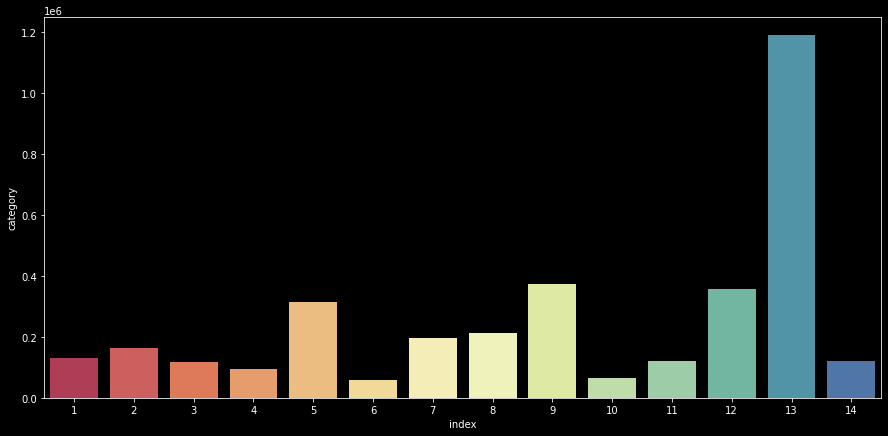

In [9]:
plt.figure(figsize = (15,7))
sns.barplot(x = a['index'], y=a['category'], palette= 'Spectral')

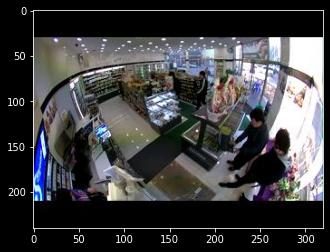

In [10]:
#See a random train image
sample = random.choice(images_train)
rando = image.load_img(train+ "/" + sample) 
plt.imshow(rando)
plt.grid(False)

### Test images

In [4]:
images_test = os.listdir(test)

In [5]:
#images_test = scandir(test)

In [6]:
categories_test = []

for filename in images_test:
    category = filename.split('_')[0] #el split, 3 elementos. el 0 es Dog or Cat
    if category == 'Abuse':
        categories_test.append(1)
    elif category == 'Arrest':
        categories_test.append(2)
    elif category == 'Arson':
        categories_test.append(3)
    elif category == 'Assault':
        categories_test.append(4)
    elif category == 'Burglary':
        categories_test.append(5)
    elif category == 'Explosion':
        categories_test.append(6)
    elif category == 'Fighting':
        categories_test.append(7)
    elif category == 'RoadAccidents':
        categories_test.append(8)
    elif category == 'Robbery':
        categories_test.append(9)
    elif category == 'Shooting':
        categories_test.append(10)
    elif category == 'Shooplifting':
        categories_test.append(11)
    elif category == 'Stealing':
        categories_test.append(12)
    elif category == 'NormalVideos':
        categories_test.append(13)
    elif category == 'Vandalism':
        categories_test.append(14)
    else:
        categories_test.append(0)

df_test = pd.DataFrame({
    'filename': images_test,
    'category': categories_test})

In [7]:
df_test.category.value_counts()

13    644728
5      16104
10      9839
4       8519
3       8164
2       7820
6       7630
11      7525
12      6007
7       4436
9       3815
8       2232
14      2078
1        162
Name: category, dtype: int64

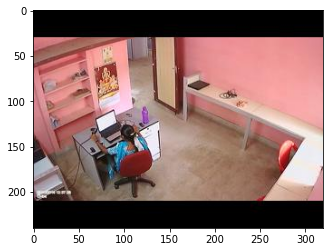

In [8]:
#See a random test image
sample = random.choice(images_test)
rando = image.load_img(test+ "/" + sample) 
plt.imshow(rando)
plt.grid(False)

In [16]:
b = df_test['category'].value_counts()
b = pd.DataFrame(b) 
b.reset_index(inplace = True)

<AxesSubplot:xlabel='index', ylabel='category'>

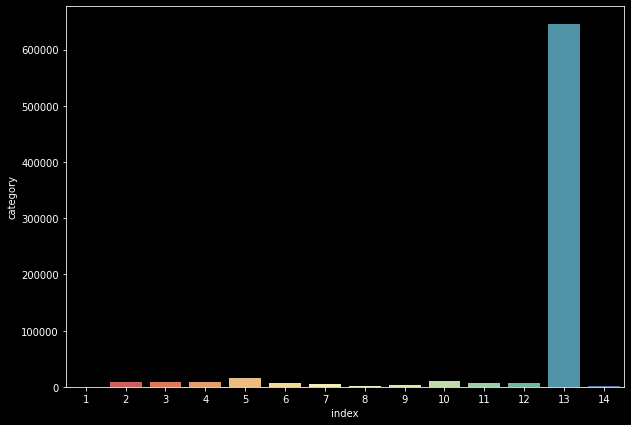

In [17]:
plt.figure(figsize = (10,7))
sns.barplot(x = b['index'], y=b['category'], palette= 'Spectral')

# Before all, define a custom activation function

In [18]:
# custom activation function
def custom_activation(output):
    logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

# Defining the models.

#### Discriminator

In [19]:
# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(120, 120, 3), n_classes=14):
# image input
    in_image = Input(shape=in_shape)
# downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
# downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
# downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
# flatten feature maps
    fe = Flatten()(fe)
# dropout
    fe = Dropout(0.4)(fe)
# output layer nodes
    fe = Dense(n_classes)(fe)
# supervised output
    c_out_layer = Activation('softmax')(fe)
# define and compile supervised discriminator model
    c_model = Model(in_image, c_out_layer)
    c_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
# unsupervised output
    d_out_layer = Lambda(custom_activation)(fe)
# define and compile unsupervised discriminator model
    d_model = Model(in_image, d_out_layer)
    d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return d_model, c_model

#### Generator

In [20]:
# define the standalone generator model
def define_generator(latent_dim):
    # image generator input
    in_lat = Input(shape=(latent_dim,))
# foundation for 120x120 image (the 15*15 is the 1/8 of the size of the image. metric given by the book)
    n_nodes = 128 * 15 * 15
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((15, 15, 128))(gen)
    # upsample to 30x30
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
# upsample to 60x60
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
# #upsample to 120x120
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
# output
    out_layer = Conv2D(3, (15, 15), activation='tanh', padding='same')(gen)
# define model
    model = Model(in_lat, out_layer)
    return model

```weight sharing is used where the output of the generator model is passed directly to the unsupervised discriminator model, and the weights of the discriminator are marked as not trainable.```

### combined generator and discriminator model (for updating the generator) 

In [21]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
# make weights in the discriminator not trainable
    d_model.trainable = False
# connect image output from generator as input to discriminator
    gan_output = d_model(g_model.output)
# define gan model as taking noise and outputting a classification
    model = Model(g_model.input, gan_output)
# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# select a supervised subset of the dataset

In [44]:
def select_supervised_samples(dataset, n_samples=250, n_classes=14):
    X_list, y_list = list(), list()
    for n in range(0, 250+1): 
        images = train_generator[n][0]
        a = cp.array(change_to_right(train_generator[n][1]))
        dlpack = a.toDlpack() 
        labels = tf.experimental.dlpack.from_dlpack(dlpack) #convert to tensor
        n_per_class = int(250/14)
        for i in range(1, 15):
        #filter images by their respective labels
            X_with_class = images[labels == i]
        # choose random instances
            ix = tnp.random.randint(0, len(X_with_class), n_per_class)
        # add each group of images to a list to train
            [X_list.append(X_with_class[j]) for j in ix]
            [y_list.append(i) for j in ix]
        print(len(X_list))
    return asarray(X_list), asarray(y_list)

In [68]:
# def select_supervised_samples(dataset, n_samples=200, n_classes=14):
#     X_list, y_list = list(), list()
#     for n in range(0, n_samples+1):
#         images = train_generator[n][0]
#         labels = tf.convert_to_tensor(tnp.array(change_to_right(train_generator[n][1])))
#         n_per_class = int(n_samples / n_classes)
#         for i in range(1, 15):
#     #filter images by their respective labels
#             X_with_class = images[labels == i]
#     # choose random instances
#             ix = tnp.random.randint(0, len(X_with_class), n_per_class)
#     # add each group of images to a list to train
#             [X_list.append(X_with_class[j]) for j in ix]
#             [y_list.append(i) for j in ix]
#         print(len(X_list))
#     return asarray(X_list), asarray(y_list)

In [ ]:
#image = train_generator[1][0] #the first [] is the batch number (so 1000 batches of 3000 images)
                              #the second [] is 0 for the images and 1 for the labels

In [ ]:
# label = train_generator[1][1]

In [ ]:
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     for x,y in train_generator:
#         print(x.shape)
#         plt.imshow(x[a])
#         plt.xticks([])
#         plt.yticks([])
#         break
# plt.tight_layout()
# plt.show()

# Select random samples from the supervised dataset

In [23]:
# select real samples
def generate_real_samples(dataset, n_samples):
# split into images and labels
    images, labels = dataset
# choose random instances
    ix = randint(0, images.shape[0], n_samples)
# select images and labels
    X, labels = images[ix], labels[ix]
# generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# Select random samples from the dataset

In [24]:
# select real samples
def generate_real_samples2(dataset, n_samples):
# split into images and labels
    dataset = train_generator
    i = random.randint(0, 1000)
    images = dataset[i][0]
    labels = tf.convert_to_tensor(tnp.array(change_to_right(train_generator[i][1])))
# choose random instances
    ix = randint(0, images.shape[0], n_samples)
# select images and labels
    X, labels = images[ix], labels[ix]
# generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

## generate points in latent space

In [25]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
# generate points in the latent space
    z_input = randn(latent_dim * n_samples)
# reshape into a batch of inputs for the network
    z_input = z_input.reshape(n_samples, latent_dim)
    return z_input

### Generate the fake images

In [26]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
# generate points in latent space
    z_input = generate_latent_points(latent_dim, n_samples)
# predict outputs
    images = generator.predict(z_input)
# create class labels
    y = zeros((n_samples, 1))
    return images, y

# save as a plot and save the model

In [17]:
def change_to_right(wrong_labels):
    right_labels=[]
    for x in wrong_labels:
        for i in range(0,len(wrong_labels[0])):
            if x[i]==1:
                right_labels.append(i+1)
    return right_labels

In [28]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
# prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
# scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
# plot images
    for i in range(100):
    # define subplot
        #plt.subplot( 1 + i)
    # turn off axis
        plt.axis('off')
    # plot raw pixel data
        plt.imshow(X[i, :, :, 0])
# save plot to file
    filename1 = 'E:/UCF_Crimes/models results/generated_plot_%04d.png' % (step+1)
    plt.savefig(filename1) 
    plt.close() 
# evaluate the classifier model
    X = train_generator[step][0]
    y = tf.convert_to_tensor(tnp.array(change_to_right(train_generator[step][1])))
    _, acc = c_model.evaluate(X, y, verbose=0)
    print('Classifier Accuracy: %.3f%%' % (acc * 100))
# save the generator model
    filename2 = 'E:/UCF_Crimes/models results/g_model_%04d.h5' % (step+1)
    g_model.save(filename2)
# save the classifier model
    filename3 = 'E:/UCF_Crimes/models results/c_model_%04d.h5' % (step+1)
    c_model.save(filename3)
    print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

# Training the models

In [29]:
#train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
# select supervised dataset
    X_sup, y_sup = select_supervised_samples(dataset)
    print(X_sup.shape, y_sup.shape)
# calculate the number of batches per training epoch
    bat_per_epo = int(X_sup.shape[0]/n_batch)
# calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
# calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    print('n_epochs=%d, n_batch=%d, 1/2=%d, bat_per_e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
# manually enumerate epochs
    for i in range(n_steps):
    # update supervised discriminator (c)
        [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
        c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
    # update unsupervised discriminator (d)
        [X_real, _], y_real = generate_real_samples2(dataset, half_batch)
        d_loss1 = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)
    # update generator (g)
        X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
    # summarize loss on this batch
        print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
    # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, c_model, latent_dim, dataset)

## size of the latent space


In [32]:
latent_dim = 300

##  create the discriminator models

In [31]:
d_model, c_model = define_discriminator()

## create the generator

In [33]:
g_model = define_generator(latent_dim)

## Create the GAN

In [34]:
gan_model = define_gan(g_model, d_model)

## load image data <<<<----- Preprocess first

In [23]:
#df_train['category'] = df_train['category'].astype('str')
df_test['category'] = df_test['category'].astype('str')

In [24]:
test_datagen = image.ImageDataGenerator(preprocessing_function=lambda x: (x - 127.5) / 127.5)

#-----opcion 1 
#(2 / 255) * x - 1) 


#----opcion 2

# def prep_fn(img):
#     img = img.astype(np.float32) / 255.0
#     img = (img - 0.5) * 2
#     return img

# gen = ImageDataGenerator(
#     preprocessing_function=prep_fn
# )

In [26]:
test_generator = test_datagen.flow_from_dataframe(
                    df_test,
                    'E:/UCF_Crimes/test_frames_label/',
                    x_col= 'filename',
                    y_col= 'category',
                    target_size= (120,120),
                    class_mode= 'categorical',
                    #subset="validation",
                    batch_size= 10000
                )

Found 729059 validated image filenames belonging to 14 classes.


In [27]:
n_samples = 10000
n_classes = 14

In [28]:
len(test_generator[1][0]) 

10000

In [ ]:
def change_to_right(wrong_labels):
    right_labels=[]
    for x in wrong_labels:
        for i in range(0,len(wrong_labels[0])):
            if x[i]==1:
                right_labels.append(i+1)
    return right_labels

In [ ]:
for n in range(3, 5):
    X_list, y_list = list(), list()
    images = test_generator[n][0]
    labels = tnp.array(change_to_right(test_generator[n][1])) #tf.convert_to_tensor() va antes de todo
    n_per_class = int(n_samples / n_classes)
    for i in range(1, 15):
    #filter images by their respective labels
        X_with_class = images[labels == i]
    # choose random instances
        ix = randint(0, len(X_with_class), n_per_class)
    # add each group of images to a list to train
        [X_list.append(X_with_class[j]) for j in ix]
        [y_list.append(i) for j in ix]
    print(n)
    filename1 = "E:/UCF_Crimes/crimes_1_255_test{}.npz".format(int(n))
    savez_compressed(filename1, X_list, y_list)
    print("Saved dataset: ", filename1)

In [25]:
# #TEST_DATAGEN

# train_datagen = image.ImageDataGenerator(
#     preprocessing_function=lambda x: (x - 127.5) / 127.5)

In [ ]:
# test_generator = train_datagen.flow_from_dataframe(
#                     df_test,
#                     'E:/UCF_Crimes/train_frames/',
#                     x_col= 'filename',
#                     y_col= 'category',
#                     target_size= (120,120),
#                     class_mode= 'categorical',
#                     batch_size= 1000
#                 )

In [38]:
dataset = train_generator

## train model

In [45]:
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

238
476
714
952
1190
1428
1666


KeyboardInterrupt: 

## Clear cache from this file

In [ ]:
# conda clean --all